In [1]:
%matplotlib inline
import torchvision
from torchvision import datasets, models, transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


training_dir = "/home/sk/data/defect_DAGM/defect_class4/train"
testing_dir = "/home/sk/data/defect_DAGM/defect_class4/test"
train_batch_size = 64
train_number_epochs = 30

In [3]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        img0 = img0.convert('RGB')
        img1 = img1.convert('RGB')
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

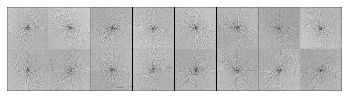

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [4]:
data_transforms =transforms.Compose([
#         transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#         transforms.RandomRotation((360) ),
    transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

folder_dataset = dset.ImageFolder(root=training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=data_transforms
                                       ,should_invert=False)

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0],example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.model_ft = models.resnet18(pretrained=True)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs,10)

    def forward_once(self, x):
        
        output = self.model_ft(x)      
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [6]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=train_batch_size)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

# print(net)

counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.1751340627670288

Epoch number 0
 Current loss 1.271183967590332

Epoch number 1
 Current loss 1.2080594301223755

Epoch number 1
 Current loss 1.2779951095581055

Epoch number 2
 Current loss 1.1230874061584473

Epoch number 2
 Current loss 1.113154411315918

Epoch number 3
 Current loss 0.8434979915618896

Epoch number 3
 Current loss 0.6924787759780884

Epoch number 4
 Current loss 0.8167315125465393

Epoch number 4
 Current loss 0.653468668460846

Epoch number 5
 Current loss 0.5843068361282349

Epoch number 5
 Current loss 0.16183707118034363

Epoch number 6
 Current loss 0.06212735176086426

Epoch number 6
 Current loss 0.17057669162750244

Epoch number 7
 Current loss 0.13318508863449097

Epoch number 7
 Current loss 0.07595524191856384

Epoch number 8
 Current loss 0.09200794994831085

Epoch number 8
 Current loss 0.013815103098750114

Epoch number 9
 Current loss 0.016357406973838806

Epoch number 9
 Current loss 0.01842423900961876

Epoch number

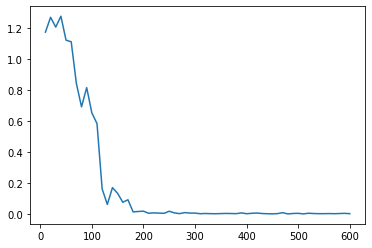

In [7]:
num_epochs = 50
for epoch in range(30):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [8]:
folder_dataset_test = dset.ImageFolder(root=testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
# x0,_,_ = next(dataiter)

In [9]:
distances_pairs,distances_no_pairs = [],[]
for i in range(len(dataiter)-1):
    
    x0,x1,label2 = next(dataiter)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    concatenated = torch.cat((x0,x1),0)
    
    if label2[0].numpy() == 0:
        distances_pairs.append( euclidean_distance.item() )
    else:
        distances_no_pairs.append( euclidean_distance.item() )

#     print(label2[0].numpy(), 'distance between pairs: {:.2f}'.format(euclidean_distance.item()) )

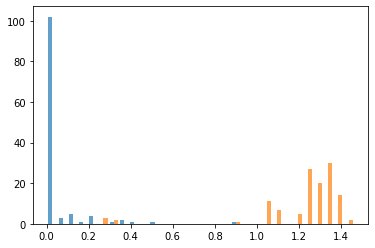

In [10]:
plt.hist([distances_pairs,distances_no_pairs], bins=30, alpha=0.7 )
plt.show()